# SGP4 test

Kerry N. Wood  (kerry.wood@asterism.ai)

Nov 24, 2024

- load a TLE and propagate to epoch
- convert to GCRS / J2K to compare our numerical propagator
- propgate
- do necessary conversions and check

In [1]:
from datetime import datetime, timedelta
import numpy as np
import astropy.time
import astropy.units as u
import matplotlib.pyplot as plt

from scipy.integrate import DOP853, solve_ivp

import perturbations

In [2]:
from sgp4.io import twoline2rv
from sgp4.earth_gravity import wgs72
from sgp4.propagation import sgp4 as sgprop

In [3]:
#  set some dates to propagate through
D1 = astropy.time.Time( datetime.utcnow() )
D2 = astropy.time.Time( D1 + timedelta( days=7 ) )
# the propagator works in seconds, SGP4 in minutes
tof = (D2.jd - D1.jd) * 86400
mins = tof / 60
# mins = (D2.jd - D1.jd) * 1440
tof_m = np.arange( 0, mins )

In [4]:
# TDRS
L1 = '1 19548U 88091B   24323.92763896 -.00000302  00000-0  00000-0 0  9993'
L2 = '2 19548  13.0440 344.8504 0039877 334.9474  23.6985  1.00266577119612'
# ISS
# L1 = '1 25544U 98067A   24324.73133691  .00020413  00000-0  36471-3 0  9992'
# L2 = '2 25544  51.6392 264.7752 0007360 236.8865 190.0358 15.49979680482676'

# find some test data
tleo = twoline2rv( L1, L2, wgs72 )

# convert this ephemeris to our frame; get the satellite epoch from the TLE
tle_atime = astropy.time.Time( tleo.jdsatepoch, format='jd' ) + ( u.min * tof_m )

# propagate and reformat the data 
tle_eph = np.vstack( [ np.hstack(sgprop( tleo, X )) for X in tof_m ] )

tle_eph_teme = astropy.coordinates.TEME( 
    obstime = tle_atime,
    x = tle_eph[:,0] * u.km,
    y = tle_eph[:,1] * u.km,
    z = tle_eph[:,2] * u.km,
    v_x = tle_eph[:,3] * u.km/u.s,
    v_y = tle_eph[:,4] * u.km/u.s,
    v_z = tle_eph[:,5] * u.km/u.s )
    
tle_eph_gcrs = tle_eph_teme.transform_to( astropy.coordinates.GCRS( obstime=tle_atime ) )    

# get the GCRS SV at epoch
tP = tle_eph_gcrs[0].cartesian.xyz.to_value(u.km)
tV = tle_eph_gcrs[0].velocity.d_xyz.to_value(u.km/u.s)

In [5]:
P = perturbations.perturbations( D1, D2 )
# P.addAll()
P.addMoon()
P.addSun()
P.addJ2()
P.addJ3()
# P.addAtmosphereExponential()

result = solve_ivp(
    P,
    (0, tof),
    np.hstack( (tP, tV) ),
    args=(),
    rtol=1e-10,
    atol=1e-12,
    method=DOP853,
    dense_output=True,
    events=None,
)

# now compare the errors
err = []
for i,m in enumerate(tof_m):
    # get the converted frame data for comparison
    ltP = tle_eph_gcrs[i].cartesian.xyz.to_value(u.km)
    ltV = tle_eph_gcrs[i].velocity.d_xyz.to_value(u.km/u.s)
    # propagated solution is in seconds
    ivps = result.sol(m*60)
    # keep the errors
    err.append( ivps - np.hstack( (ltP, ltV) ) )
err = np.vstack(err)

Initialized body_interp: 1728 total points, 600 second spacing, 1036200.0077202916 max offset, moon_callable function
Initialized body_interp: 1728 total points, 600 second spacing, 1036200.0077202916 max offset, sun_callable function


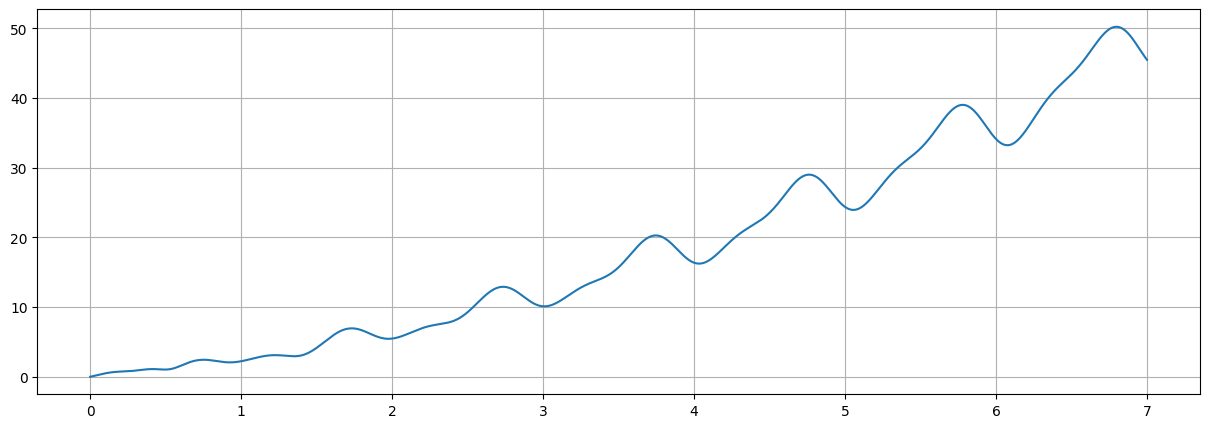

In [7]:
plt.close('all')
plt.figure( figsize=(15,5) )
plt.plot( tof_m / (24*60), np.linalg.norm( err[:,0:3] , axis=1 ) )
plt.grid()